In [1]:
import pulp as plp

# Definer modellen
model = plp.LpProblem("Fritidsklub", plp.LpMinimize)

# Golfhandicap liste
Forhånd = [0, 1.2, 1.4, 2.1, 2.3, 2.9, 3.5, 4.1, 4.9, 5.4, 5.7, 6.2, 6.8]

# Skab kanter (Arcs) mellem spillere
# kanter 
arcs = [(i, j) for i in range(12) for j in range(i+3, min(i+6, 13))]

# Beslutningsvariable
x = plp.LpVariable.dicts("x", arcs, 0, None)

# Objektfunktion (minimer forskellen i Forhåndskendskab)
model += plp.lpSum((Forhånd[j] - Forhånd[i+1]) * x[(i, j)] for i, j in arcs)

# Kilde- og afløbsbegrænsninger
# Sikre at vi starer i punkt 0 og slutter i punkt 12
model += plp.lpSum(x[a] for a in arcs if a[0] == 0) == 1
model += plp.lpSum(x[a] for a in arcs if a[1] == 12) == 1

# Balancebegrænsninger
# inflow og outflow skal være lig hinanden  
for k in range(1, 12):
    model += plp.lpSum(x[a] for a in arcs if a[0] == k) == plp.lpSum(x[a] for a in arcs if a[1] == k)

# Løs modellen
model.solve(plp.PULP_CBC_CMD(msg=False))

# Print resultat
print("Status:", plp.LpStatus[model.status])
for (i, j) in arcs:
    if x[(i, j)].varValue > 0.01:
        print(f"Fra {i} til {j}: Omk. {round(Forhånd[j] - Forhånd[i+1], 1)}")

print("Objektiv værdi:", plp.value(model.objective))

Status: Optimal
Fra 0 til 4: Omk. 1.1
Fra 4 til 7: Omk. 1.2
Fra 7 til 12: Omk. 1.9
Objektiv værdi: 4.199999999999999


# Anden løsning 

In [5]:
import pulp as plp

# Definer modellen
model = plp.LpProblem("NET-2", plp.LpMinimize)


# Golfhandicap liste
Forhånd = [0, 1.2, 1.4, 2.1, 2.3, 2.9, 3.5, 4.1, 4.9, 5.4, 5.7, 6.2, 6.8]


# Skab kanter (Arcs) mellem spillere
arcs = [(i, j) for i in range(12) for j in range(i+3, min(i+6, 13))]


# Beslutningsvariable
x = plp.LpVariable.dicts("x", arcs, 0, None)


# Objektfunktion (minimer forskellen i handicap)
model += plp.lpSum((Forhånd[j] - Forhånd[i+1]) * x[(i, j)] for i, j in arcs)

# Kilde- og afløbsbegrænsninger
model += plp.lpSum(x[a] for a in arcs if a[0] == 0) == 1
model += plp.lpSum(x[a] for a in arcs if a[1] == 12) == 1

# Balancebegrænsninger
for k in range(1, 12):
    model += plp.lpSum(x[(i, k)] for i in range(k-4, k-2) if (i, k) in arcs) == plp.lpSum(x[(k, j)] for j in range(k+3, k+6) if (k, j) in arcs)

# Løs modellen
model.solve(plp.PULP_CBC_CMD(msg=False))

# Print resultat
print("Status:", plp.LpStatus[model.status])
for (i, j) in arcs:
    if x[(i, j)].varValue > 0.01:
        print(f"Fra {i} til {j}: Omk. {round(Forhånd[j] - Forhånd[i+1], 1)}")

print("Objektiv værdi:", plp.value(model.objective))


Status: Optimal
Fra 0 til 4: Omk. 1.1
Fra 4 til 7: Omk. 1.2
Fra 7 til 12: Omk. 1.9
Objektiv værdi: 4.199999999999999


# Opgave 2 

Der betragtes stadig problemstillingen i spm. 1) bortset fra, at der nu benyttes et
andet kriterium. Kravene til en brugbar løsning er s˚aledes uændrede i forhold til
spm. 1). En brugbar løsning er s˚aledes ogs˚a stadig givet ved en vej i et konstrueret
netværk af den type, der blev bedt om i spm. 1). Som omkostning for en s˚adan vej
benyttes imidlertid nu ikke vejens længde, men blot omkostningen p˚a den dyreste
af de kanter, der er benyttet p˚a vejen. Kriteriet er stadig omkostningsminimering,
s˚a der ønskes nu en gruppeinddeling, hvor den dyreste kant p˚a vejen er billigst
mulig. Forklar, hvad der kan være hensigtsmæssigt ved dette kriterium i den givne
situation. Forklar desuden, hvorledes en matematisk model kan formuleres med dette
kriterium. Opstil og løs modellen i Python/PuLP, og beskriv den optimale løsnin

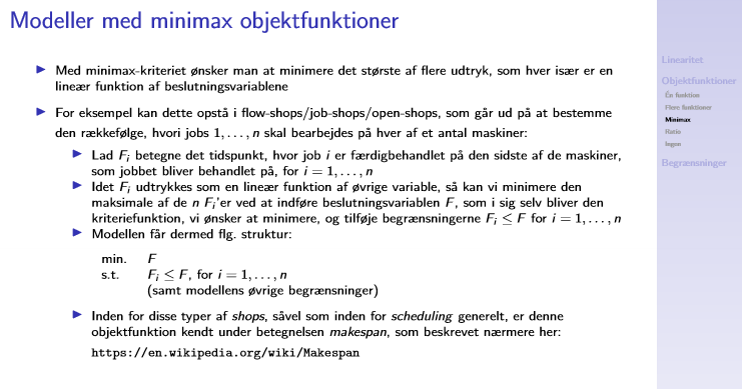

In [6]:
import pulp as plp

# Definer modellen
model = plp.LpProblem("Minimer_dyreste_kant", plp.LpMinimize)

# Forhåndskendskabsliste (index 0 er dummy-start)
F = [0, 1.2, 1.4, 2.1, 2.3, 2.9, 3.5, 4.1, 4.9, 5.4, 5.7, 6.2, 6.8]

n = 12
# Mulige kanter mellem spiller i grupper af størrelse 3 til 5
arcs = [(i, j) for i in range(n) for j in range(i+3, min(i+6, n+1))]

# Beslutningsvariable for hver kant (1 hvis kant vælges, 0 ellers)
x = plp.LpVariable.dicts("x", arcs, 0, 1, plp.LpBinary)

# Variabel for maksimal omkostning
z = plp.LpVariable("z", 0, None)

# Omkostning pr. kant
cost = {(i, j): F[j] - F[i+1] for (i, j) in arcs}

# Objektfunktion: minimer den dyreste (maksimale) kant i løsningen
model += z

# Begrænsninger: z skal være mindst så stor som hver valgt kant
for (i, j) in arcs:
    model += z >= cost[(i, j)] * x[(i, j)]

# Kilde- og afløbsbegrænsninger
model += plp.lpSum(x[(i, j)] for (i, j) in arcs if i == 0) == 1
model += plp.lpSum(x[(i, j)] for (i, j) in arcs if j == n) == 1

# Flow-begrænsninger (balance) for interne noder
for k in range(1, n):
    model += plp.lpSum(x[(i, j)] for (i, j) in arcs if i == k) == plp.lpSum(x[(i, j)] for (i, j) in arcs if j == k)

# Løs modellen
model.solve(plp.PULP_CBC_CMD(msg=False))

# Resultat
print("Status:", plp.LpStatus[model.status])
print("Maksimal kantomkostning:", round(plp.value(z), 2))

for (i, j) in arcs:
    if x[(i, j)].varValue > 0.5:
        print(f"Gruppe fra {i+1} til {j}: medlemmer {list(range(i+1, j+1))}, omk. = {round(cost[(i,j)], 2)}")


Status: Optimal
Maksimal kantomkostning: 1.3
Gruppe fra 1 til 3: medlemmer [1, 2, 3], omk. = 0.9
Gruppe fra 4 til 6: medlemmer [4, 5, 6], omk. = 1.2
Gruppe fra 7 til 9: medlemmer [7, 8, 9], omk. = 1.3
Gruppe fra 10 til 12: medlemmer [10, 11, 12], omk. = 1.1
